In [16]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r3.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

In [17]:
df = df_raw.copy()

df = df[df['model']=='Resnet18']
df = df[df['read_noise_scale'] == 0]
df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']=='default']
df = df[(df['inp_noise']==0.01)]
df = df[(df['GDC']=='on')]

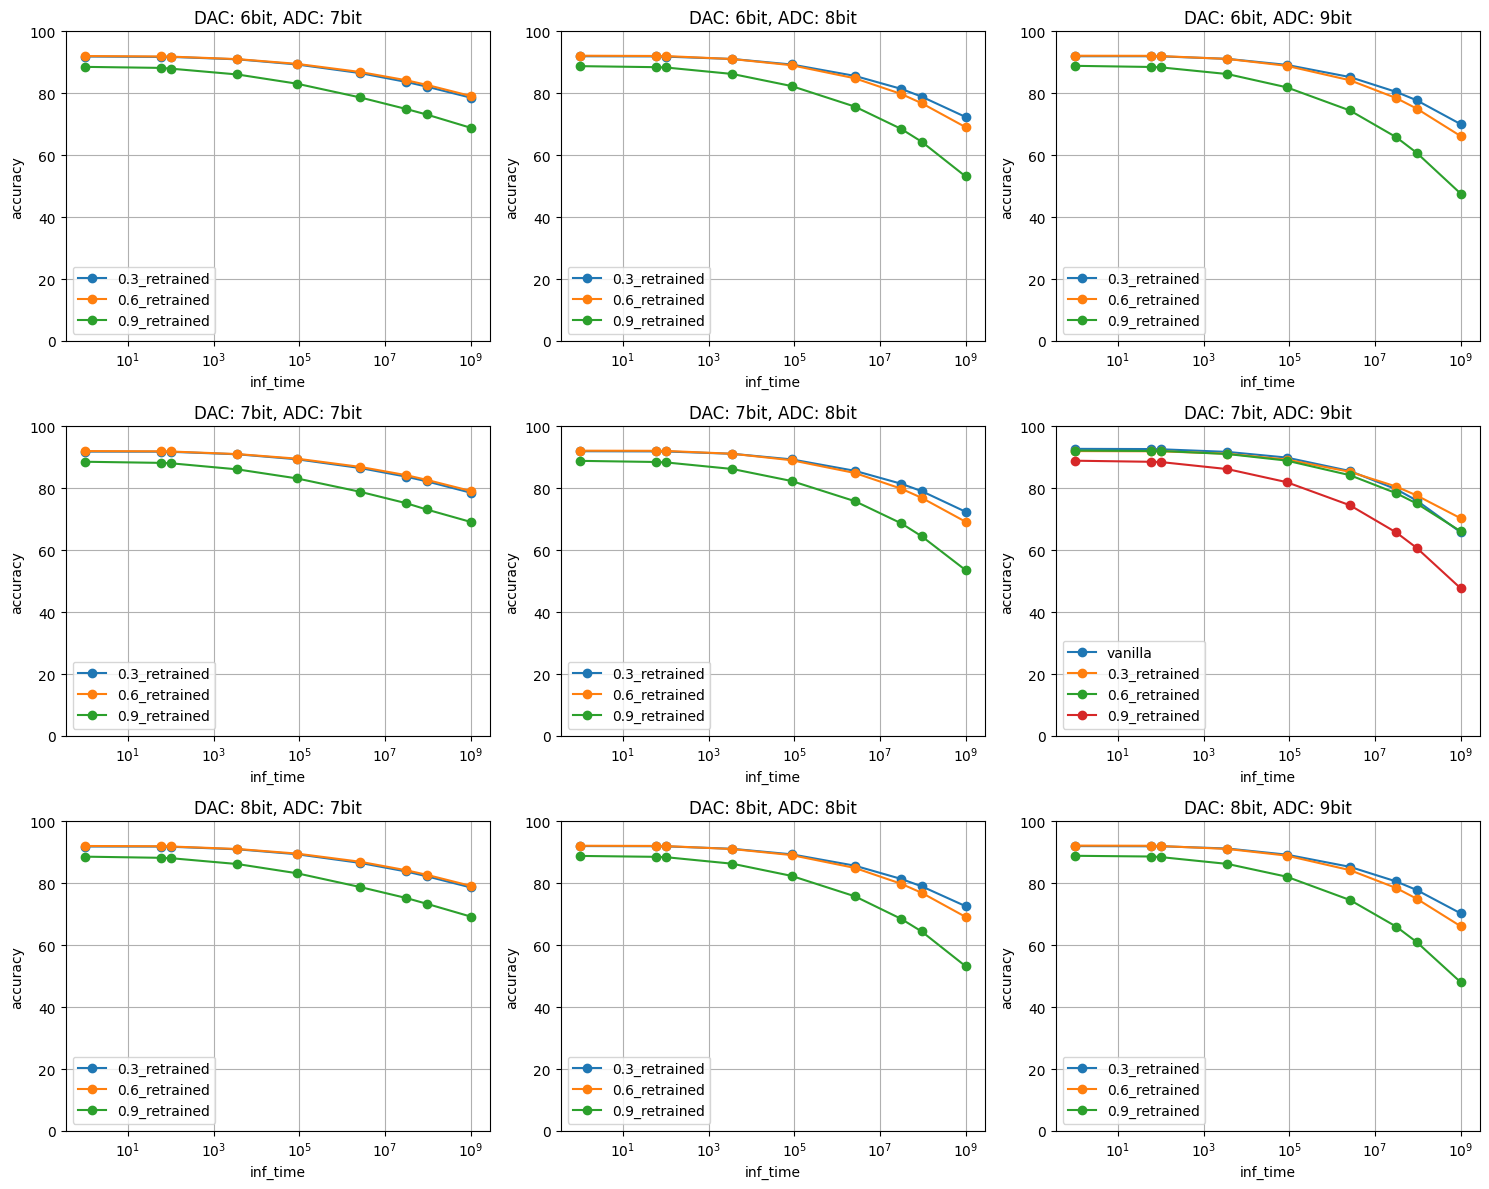

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 예시용: rawdata = pd.read_csv("your_data.csv")

# 필요한 열이 존재하는지 확인

required_columns = {'inf_time', 'accuracy', 'model_type', 'dac_res', 'adc_res'}
assert required_columns.issubset(df.columns), "필수 column이 rawdata에 없습니다."

# 유일한 dac_res, adc_res 값 파악
dac_vals = sorted(df['dac_res'].unique())
adc_vals = sorted(df['adc_res'].unique())

# subplot 생성
fig, axes = plt.subplots(len(dac_vals), len(adc_vals), figsize=(5 * len(adc_vals), 4 * len(dac_vals)), squeeze=False)

# 각 subplot에 대해 plot
for i, dac in enumerate(dac_vals):
    for j, adc in enumerate(adc_vals):
        ax = axes[i][j]
        subset = df[(df['dac_res'] == dac) & (df['adc_res'] == adc)]
        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model]
            ax.plot(model_data['inf_time'], model_data['accuracy'], label=model, marker='o')

        ax.set_title(f'DAC: {dac}, ADC: {adc}')
        ax.set_xlabel('inf_time')
        ax.set_ylabel('accuracy')
        ax.set_xscale('log')
        ax.set_ylim(0, 100)
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()
